In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Session = sessionmaker(bind=engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\swire\AppData\Local\Temp\ipykernel_20876\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the dataset is:", most_recent_date)


The most recent date in the dataset is: 2017-08-23


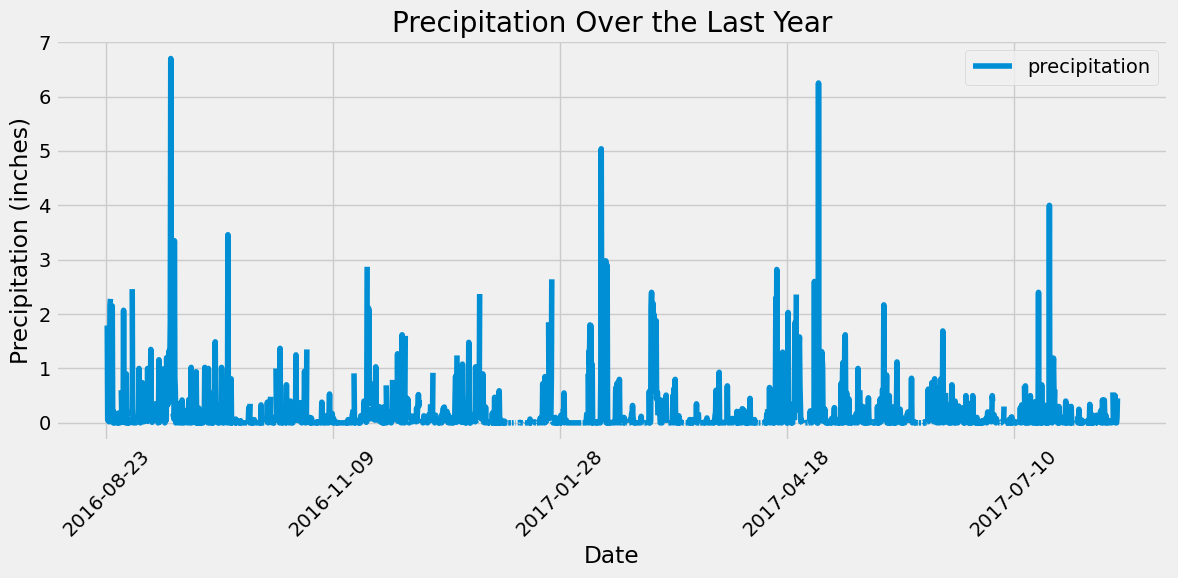

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_query = session.query(func.max(Measurement.date)).first()
recent_date = recent_date_query[0]
# Calculate the date one year from the last date in data set.
recent_date = datetime.strptime(recent_date, '%Y-%m-%d')
one_year_ago = recent_date - timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
# Sort the dataframe by date
precipitation_df.sort_values('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', kind='line', figsize=(12, 6), title='Precipitation Over the Last Year')
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Precipitation (inches)')  # Set the y-axis label
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Convert the Series to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics)
summary_statistics_df = pd.DataFrame(summary_statistics).reset_index()

# Rename the columns for clarity
summary_statistics_df.columns = ['Statistic', 'Precipitation']

# Set the index to the first column
summary_statistics_df.set_index('Statistic', inplace=True)
summary_statistics_df

,Precipitation
Statistic,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id.distinct())).scalar()
print(total_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = (
    session.query(Station.station, func.count(Measurement.station).label('count'))  # Count the number of associated measurements
    .join(Measurement, Measurement.station == Station.station)  # Ensure this matches your Measurement model
    .group_by(Station.station)  # Group by station ID
    .order_by(func.count(Measurement.station).desc())  # Order by count in descending order
).all()
# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f'{station}, {count}')

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).one()

# Print the results
print(f"{temperature_stats.min_temp}, {temperature_stats.max_temp}, {temperature_stats.avg_temp}")

54.0, 85.0, 71.66378066378067


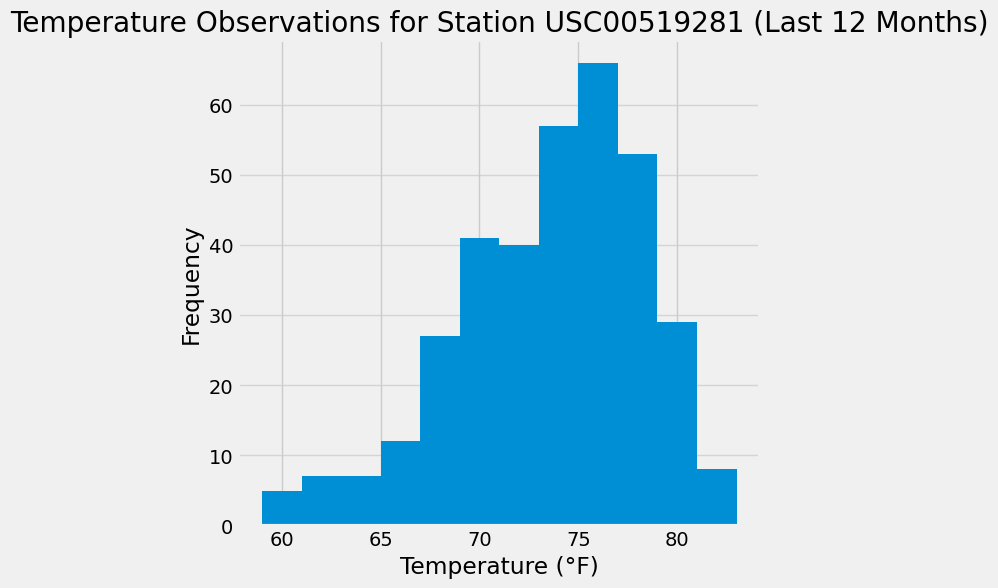

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Define the most active station ID
most_active_station_id = 'USC00519281'

# Starting from the most recent data point in the database. 
recent_date_query = session.query(func.max(Measurement.date)).first()
recent_date = recent_date_query[0]
# Calculate the date one year from the last date in data set.
recent_date = datetime.strptime(recent_date, '%Y-%m-%d')
one_year_ago = recent_date - timedelta(days=366)
# Query to get the last 12 months of temperature observations for the most active station
results = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago,
    Measurement.date <= recent_date
).all()

# Convert results to a Pandas DataFrame
tobs_data = pd.DataFrame(results, columns=['tobs'])

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(tobs_data['tobs'].dropna(), bins=12)  # Drop NaN values
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(range(60, 85, 5))
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()